In [1]:
import re
import pandas as pd
from collections import OrderedDict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pymystem3 import Mystem
from string import punctuation

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
novel = "data/Толстой, Лев Николаевич - Анна Каренина.txt"

In [3]:
with open(novel, 'r') as f:
    raw_text = f.read()

In [4]:
raw_text[:5000]

'Лев Николаевич Толстой\n\nАнна Каренина\n\n                                                 Мне отмщение, и аз воздам\n\n                                ЧАСТЬ ПЕРВАЯ\n\n                                     I\n\n  Все счастливые семьи похожи друг на друга, каждая  несчастливая\nсемья несчастлива по-своему.\n  Все смешалось в доме Облонских. Жена узнала, что муж  был  в  связи  с\nбывшею в их доме француженкою-гувернанткой, и объявила мужу, что не  мо-\nжет жить с ним в одном доме. Положение это продолжалось уже третий  день\nи мучительно чувствовалось и самими супругами, и всеми членами семьи,  и\nдомочадцами. Все члены семьи и домочадцы чувствовали, что нет  смысла  в\nих сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди\nболее связаны между собой, чем они, члены семьи и  домочадцы  Облонских.\nЖена не выходила из своих комнат, мужа третий день не  было  дома.  Дети\nбегали по всему дому, как потерянные; англичанка поссорилась с экономкой\nи написала записку прияте

In [5]:
# Remove erroneous double-spaces
text = re.sub(r"(?<=[А-Яа-я,-])(\s\s)(?=[А-Яа-я,-])", " ", raw_text)

# Remove hyphens in words split by line break
text = re.sub(r"(?<=[А-Яа-я])(-\n)(?=[А-Яа-я])", "", text)

# Remove unnecessary line breaks
# text = re.sub(r"(?:[А-Яа-я])(\n)(?:[А-Яа-я\n \.])", "", raw_text)
text = re.sub(r"(?<!\n)(\n)(?!(  |\n))", " ", text)

In [6]:
(raw_text[:5000])

'Лев Николаевич Толстой\n\nАнна Каренина\n\n                                                 Мне отмщение, и аз воздам\n\n                                ЧАСТЬ ПЕРВАЯ\n\n                                     I\n\n  Все счастливые семьи похожи друг на друга, каждая  несчастливая\nсемья несчастлива по-своему.\n  Все смешалось в доме Облонских. Жена узнала, что муж  был  в  связи  с\nбывшею в их доме француженкою-гувернанткой, и объявила мужу, что не  мо-\nжет жить с ним в одном доме. Положение это продолжалось уже третий  день\nи мучительно чувствовалось и самими супругами, и всеми членами семьи,  и\nдомочадцами. Все члены семьи и домочадцы чувствовали, что нет  смысла  в\nих сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди\nболее связаны между собой, чем они, члены семьи и  домочадцы  Облонских.\nЖена не выходила из своих комнат, мужа третий день не  было  дома.  Дети\nбегали по всему дому, как потерянные; англичанка поссорилась с экономкой\nи написала записку прияте

In [7]:
print(text[:15000])

Лев Николаевич Толстой Анна Каренина

                                                 Мне отмщение, и аз воздам

                                ЧАСТЬ ПЕРВАЯ

                                     I

  Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.
  Все смешалось в доме Облонских. Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой, и объявила мужу, что не может жить с ним в одном доме. Положение это продолжалось уже третий день и мучительно чувствовалось и самими супругами, и всеми членами семьи, и домочадцами. Все члены семьи и домочадцы чувствовали, что нет смысла в их сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди более связаны между собой, чем они, члены семьи и домочадцы Облонских. Жена не выходила из своих комнат, мужа третий день не было дома.  Дети бегали по всему дому, как потерянные; англичанка поссорилась с экономкой и написала записку приятельнице, прося приискать ей новое место;

In [8]:
ak = OrderedDict()

parts = re.findall(r"(ЧАСТЬ [А-Я]+)", text)  # Split the book into the different parts

for part in parts:
    part_text = re.search(r"{}([\w\W:]*?)(ЧАСТЬ|Конец\s*\n)".format(part), text)  # Extract the content of each part
    chapters = re.findall(r"\n*\s*([IVX]+)\n*([\w\W:]*?)(?=\s{5}[IVX]+(?![a-z])|$)", part_text.group(1))  # Extract the chapter number and text for each part
    chapters = OrderedDict([(item[0], item[1].rstrip()) for item in chapters])
    ak[part] = OrderedDict(chapters)

### The format of the Anna Karenina ak dictionary is as follows:
&nbsp;   
{part 1: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'part 2': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [9]:
# Word Count
for part in ak:
    print('{:,} words in {}'.format(sum(len(ak[part][chapter].split()) for chapter in ak[part]), part))
print()    
print('{:,} total words in Анна Каренина'.format(sum(len(ak[part][chapter].split())
                                                for part in ak
                                                for chapter in ak[part])))

39,776 words in ЧАСТЬ ПЕРВАЯ
41,394 words in ЧАСТЬ ВТОРАЯ
40,486 words in ЧАСТЬ ТРЕТЬЯ
28,378 words in ЧАСТЬ ЧЕТВЕРТАЯ
39,878 words in ЧАСТЬ ПЯТАЯ
39,903 words in ЧАСТЬ ШЕСТАЯ
33,900 words in ЧАСТЬ СЕДЬМАЯ
16,356 words in ЧАСТЬ ВОСЬМАЯ

280,071 total words in Анна Каренина


In [10]:
# Average word length
for part in ak:
    text = ''
    for chapter in ak[part]:
        text = text + ak[part][chapter]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), part))

6.09 Average word length in ЧАСТЬ ПЕРВАЯ
6.12 Average word length in ЧАСТЬ ВТОРАЯ
6.18 Average word length in ЧАСТЬ ТРЕТЬЯ
6.14 Average word length in ЧАСТЬ ЧЕТВЕРТАЯ
6.15 Average word length in ЧАСТЬ ПЯТАЯ
6.14 Average word length in ЧАСТЬ ШЕСТАЯ
6.08 Average word length in ЧАСТЬ СЕДЬМАЯ
6.14 Average word length in ЧАСТЬ ВОСЬМАЯ


In [11]:
# Chapters in parts
for part in ak:
    chapters = 0
    for chapter in ak[part]:
        chapters += 1
    print('{} chapters in {}'.format(chapters, part))

34 chapters in ЧАСТЬ ПЕРВАЯ
35 chapters in ЧАСТЬ ВТОРАЯ
32 chapters in ЧАСТЬ ТРЕТЬЯ
23 chapters in ЧАСТЬ ЧЕТВЕРТАЯ
33 chapters in ЧАСТЬ ПЯТАЯ
32 chapters in ЧАСТЬ ШЕСТАЯ
31 chapters in ЧАСТЬ СЕДЬМАЯ
19 chapters in ЧАСТЬ ВОСЬМАЯ


In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.extend(['это'])

In [13]:
# Convert to list
data = [ak[part][chapter].replace('\n', '') for part in ak for chapter in ak[part]]
print(data[1])

  Степан Аркадьич был человек правдивый в отношении к себе самому. Он не мог обманывать себя и уверять себя, что он раскаивается в своем поступке. Он не мог теперь раскаиваться в том, что он, тридцатичетырехлетний, красивый, влюбчивый человек, не был влюблен в жену, мать пяти живых и двух умерших детей, бывшую только годом моложе его.  Он раскаивался только в том, что не умел лучше скрыть от жены. Но он чувствовал всю тяжесть своего положения и жалел жену, детей и себя. Может быть, он сумел бы лучше скрыть свои грехи от жены, если б ожидал, что это известие так на нее подействует. Ясно он никогда не обдумывал этого вопроса, но смутно ему представлялось, что жена давно догадывается, что он не верен ей, и смотрит на это сквозь пальцы. Ему даже казалось, что она, истощенная, состарившаяся, уже некрасивая женщина и ничем не замечательная, простая, только добрая мать семейства, по чувству справедливости должна быть снисходительна. Оказалось совсем противное.  "Ах, ужасно! ай, ай, ай! ужасно

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['все', 'счастливые', 'семьи', 'похожи', 'друг', 'на', 'друга', 'каждая', 'несчастливая', 'семья', 'несчастлива', 'по', 'своему', 'все', 'смешалось', 'доме', 'облонских', 'жена', 'узнала', 'что', 'муж', 'был', 'связи', 'бывшею', 'их', 'доме', 'француженкою', 'гувернанткои', 'объявила', 'мужу', 'что', 'не', 'может', 'жить', 'ним', 'одном', 'доме', 'положение', 'это', 'продолжалось', 'уже', 'третии', 'день', 'мучительно', 'чувствовалось', 'самими', 'супругами', 'всеми', 'членами', 'семьи', 'домочадцами', 'все', 'члены', 'семьи', 'домочадцы', 'чувствовали', 'что', 'нет', 'смысла', 'их', 'сожительстве', 'что', 'на', 'каждом', 'постоялом', 'дворе', 'случаино', 'сошедшиеся', 'люди', 'более', 'связаны', 'между', 'собои', 'чем', 'они', 'члены', 'семьи', 'домочадцы', 'облонских', 'жена', 'не', 'выходила', 'из', 'своих', 'комнат', 'мужа', 'третии', 'день', 'не', 'было', 'дома', 'дети', 'бегали', 'по', 'всему', 'дому', 'как', 'потерянные', 'англичанка', 'поссорилась', 'экономкои', 'написала', 'з

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/envs/py3.6/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['все', 'счастливые', 'семьи', 'похожи', 'друг', 'на', 'друга', 'каждая', 'несчастливая', 'семья', 'несчастлива', 'по', 'своему', 'все', 'смешалось', 'доме', 'облонских', 'жена', 'узнала', 'что', 'муж', 'был', 'связи', 'бывшею', 'их', 'доме', 'француженкою', 'гувернанткои', 'объявила', 'мужу', 'что', 'не', 'может', 'жить', 'ним', 'одном', 'доме', 'положение', 'это', 'продолжалось', 'уже', 'третии_день', 'мучительно', 'чувствовалось', 'самими', 'супругами', 'всеми', 'членами', 'семьи', 'домочадцами', 'все', 'члены', 'семьи', 'домочадцы', 'чувствовали', 'что', 'нет', 'смысла', 'их', 'сожительстве', 'что', 'на', 'каждом', 'постоялом', 'дворе', 'случаино', 'сошедшиеся', 'люди', 'более', 'связаны', 'между', 'собои', 'чем', 'они', 'члены', 'семьи', 'домочадцы', 'облонских', 'жена', 'не', 'выходила', 'из', 'своих', 'комнат', 'мужа', 'третии_день', 'не', 'было', 'дома', 'дети', 'бегали', 'по', 'всему', 'дому', 'как', 'потерянные', 'англичанка', 'поссорилась', 'экономкои', 'написала', 'записку'

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    text_out = []
    for doc in texts:
        text = " ".join(doc)
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]
        text_out.append(tokens)
    return text_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['счастливый', 'семья', 'похожий', 'друг', 'друг', 'каждый', 'несчастливый', 'семья', 'несчастливый', 'свой', 'смешаться', 'дом', 'облонский', 'жена', 'узнавать', 'муж', 'связь', 'дом', 'француженка', 'гувернанткои', 'объявлять', 'муж', 'жить', 'дом', 'положение', 'продолжаться', 'третия', 'день', 'мучительно', 'чувствоваться', 'супруга', 'весь', 'член', 'семья', 'домочадец', 'член', 'семья', 'домочадец', 'чувствовать', 'смысл', 'сожительство', 'каждый', 'постоялый', 'двор', 'случаина', 'сходиться', 'человек', 'связанный', 'собой', 'член', 'семья', 'домочадец', 'облонский', 'жена', 'выходить', 'свой', 'комната', 'муж', 'третия', 'день', 'дома', 'ребенок', 'бегать', 'весь', 'дом', 'потерянный', 'англичанка', 'поссориться', 'экономкои', 'написать', 'записка', 'приятельница', 'просить', 'приискивать', 'еи', 'новый', 'место', 'повар', 'уходить', 'вчера', 'двор', 'время', 'обед', 'черный', 'кухарка', 'кучер', 'просить', 'расчет', 'третия', 'день', 'ссора', 'князь', 'степан', 'аркадьич', 'о

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 5), (9, 6), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 6), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 4), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 3), (54, 2), (55, 1), (56, 2), (57, 4), (58, 4), (59, 1), (60, 1), (61, 2), (62, 4), (63, 1), (64, 3), (65, 1), (66, 2), (67, 3), (68, 2), (69, 1), (70, 8), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 2), (87, 1), (88, 1), (89, 2), (90, 2), (91, 1), (92, 1), (93, 1), (94, 3), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101, 1), (102, 4), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1), (110, 2)

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('il', 2),
  ('mio', 2),
  ('tesoro', 2),
  ('ааа', 1),
  ('алабин', 2),
  ('америка', 1),
  ('американский', 1),
  ('англичанка', 1),
  ('аркадьич', 5),
  ('ах', 6),
  ('бегать', 1),
  ('безвыходность', 1),
  ('боль', 1),
  ('бывать', 1),
  ('вернуться', 1),
  ('весело', 2),
  ('веселыи', 1),
  ('весь', 6),
  ('вечно', 1),
  ('вздрагивать', 1),
  ('видеть', 1),
  ('вина', 2),
  ('виноватый', 1),
  ('виноя', 3),
  ('висеть', 1),
  ('вместо', 1),
  ('воображение', 1),
  ('восемь', 1),
  ('воспоминание', 1),
  ('впечатление', 1),
  ('время', 1),
  ('вскакивать', 1),
  ('вспоминать', 4),
  ('вспомнить', 1),
  ('вставать', 1),
  ('вчера', 1),
  ('выбегать', 1),
  ('выражать', 1),
  ('выражение', 1),
  ('выходить', 1),
  ('выхоливать', 1),
  ('глаз', 2),
  ('глупый', 3),
  ('гнев', 1),
  ('говорить', 1),
  ('год', 1),
  ('головной', 1),
  ('горячность', 1),
  ('гостиноя', 1),
  ('графинчик', 1),
  ('грушея', 1),
  ('гувернанткои', 1),
  ('давать', 2),
  ('дармштадт', 3),
  ('двор', 2),
  

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.071*"дарья" + 0.069*"александровна" + 0.014*"коляска" + 0.008*"лошадей" + '
  '0.008*"лошадь" + 0.007*"кучер" + 0.006*"девочка" + 0.005*"англичанка" + '
  '0.005*"козлы" + 0.005*"шлюпик"'),
 (1,
  '0.028*"доброволец" + 0.026*"катавас" + 0.025*"воин" + 0.024*"сергей" + '
  '0.016*"народ" + 0.015*"иванович" + 0.012*"станция" + 0.012*"катавасов" + '
  '0.011*"князь" + 0.011*"турок"'),
 (2,
  '0.010*"пузырек" + 0.007*"шопенгауер" + 0.007*"заваливаться" + '
  '0.007*"хомяков" + 0.007*"повеситься" + 0.006*"застреливаться" + '
  '0.006*"непогрешимый" + 0.004*"искупление" + 0.004*"строиться" + '
  '0.003*"томить"'),
 (3,
  '0.028*"голенищев" + 0.025*"картина" + 0.011*"михаил" + 0.011*"художник" + '
  '0.010*"понятие" + 0.009*"святой" + 0.009*"разрушать" + 0.009*"коса" + '
  '0.008*"ряд" + 0.008*"михаилов"'),
 (4,
  '0.013*"серпуховскои" + 0.010*"командир" + 0.009*"полковой" + '
  '0.006*"серпуховский" + 0.004*"пруссиеи" + 0.004*"краснощекий" + 0.004*"бас" '
  '+ 0.004*"преимущество" 

In [22]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -8.099017590816848
Coherence Score:  0.3568828497658759


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/envs/py3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [24]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('вронский', 0.10321615557217652),
   ('свой', 0.0218773373223635),
   ('женщина', 0.01907255048616305),
   ('яшвин', 0.012902019446522065),
   ('человек', 0.012715033657442034),
   ('офицер', 0.008414360508601346),
   ('давать', 0.007853403141361256),
   ('молодой', 0.007853403141361256),
   ('входить', 0.006918474195961107),
   ('выпивать', 0.006918474195961107)]),
 (1,
  [('сказать', 0.13623595505617977),
   ('улыбаться', 0.02593632958801498),
   ('отвечать', 0.025),
   ('говорить', 0.0249063670411985),
   ('рука', 0.02144194756554307),
   ('глаз', 0.016198501872659175),
   ('понимать', 0.014044943820224719),
   ('продолжать', 0.01245318352059925),
   ('думать', 0.012359550561797753),
   ('улыбкои', 0.012359550561797753)]),
 (2,
  [('мысль', 0.024541496239609446),
   ('который', 0.02427760918326956),
   ('жизнь', 0.0234859480142499),
   ('жить', 0.02111096450719092),
   ('думать', 0.019923472753661433),
   ('иметь', 0.015833223380393193),
   ('знать', 0.015437392795883362),


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


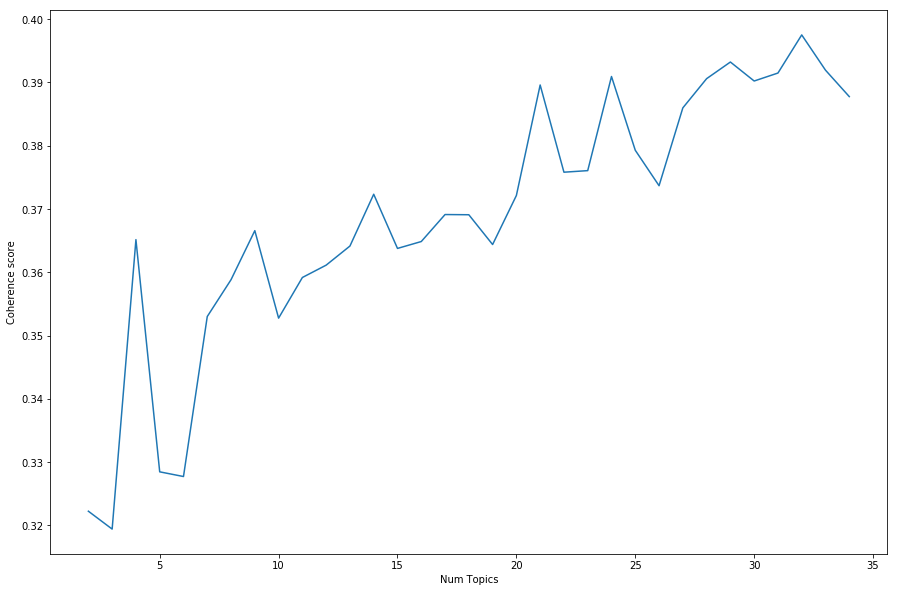

In [28]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.322242
Num Topics = 3  has Coherence Value of 0.319416
Num Topics = 4  has Coherence Value of 0.365163
Num Topics = 5  has Coherence Value of 0.328465
Num Topics = 6  has Coherence Value of 0.327724
Num Topics = 7  has Coherence Value of 0.353011
Num Topics = 8  has Coherence Value of 0.358833
Num Topics = 9  has Coherence Value of 0.366582
Num Topics = 10  has Coherence Value of 0.352757
Num Topics = 11  has Coherence Value of 0.359179
Num Topics = 12  has Coherence Value of 0.361131
Num Topics = 13  has Coherence Value of 0.36415
Num Topics = 14  has Coherence Value of 0.372337
Num Topics = 15  has Coherence Value of 0.363774
Num Topics = 16  has Coherence Value of 0.364862
Num Topics = 17  has Coherence Value of 0.369129
Num Topics = 18  has Coherence Value of 0.369096
Num Topics = 19  has Coherence Value of 0.36439
Num Topics = 20  has Coherence Value of 0.372139
Num Topics = 21  has Coherence Value of 0.389605
Num Topics = 22  has Coherence

In [30]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 16
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.087*"степан" + 0.087*"аркадьич" + 0.045*"сказать" + 0.020*"облонский" + '
  '0.012*"очень" + 0.010*"знать" + 0.009*"давать" + 0.009*"улыбаться" + '
  '0.008*"место" + 0.008*"дело"'),
 (1,
  '0.029*"мужик" + 0.029*"левин" + 0.012*"дорога" + 0.012*"старик" + '
  '0.011*"земля" + 0.011*"хозяиства" + 0.011*"хозяиство" + 0.010*"рабочий" + '
  '0.010*"свой" + 0.009*"год"'),
 (2,
  '0.020*"нога" + 0.018*"лошадь" + 0.014*"который" + 0.009*"кучер" + '
  '0.009*"самый" + 0.009*"место" + 0.008*"вагон" + 0.008*"ласка" + '
  '0.008*"весловския" + 0.008*"болото"'),
 (3,
  '0.020*"доктор" + 0.020*"рука" + 0.017*"чувствовать" + 0.016*"чувство" + '
  '0.012*"смерть" + 0.011*"голова" + 0.011*"становиться" + 0.011*"свой" + '
  '0.011*"умирать" + 0.010*"бог"'),
 (4,
  '0.060*"анна" + 0.046*"еи" + 0.029*"сказать" + 0.028*"нея" + 0.023*"муж" + '
  '0.017*"мочь" + 0.016*"видеть" + 0.016*"сын" + 0.014*"который" + '
  '0.013*"положение"'),
 (5,
  '0.043*"долли" + 0.035*"ребенок" + 0.031*"александровн

In [31]:
optimal_model.show_topic(0,10)

[('степан', 0.0870595670722073),
 ('аркадьич', 0.0869015642281561),
 ('сказать', 0.044556802022436406),
 ('облонский', 0.020224364038552694),
 ('очень', 0.011534207615737084),
 ('знать', 0.010112182019276347),
 ('давать', 0.00916416495496919),
 ('улыбаться', 0.008532153578764417),
 ('место', 0.008374150734713225),
 ('дело', 0.007900142202559647)]

In [32]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['степан', 'аркадьич', 'сказать', 'облонский', 'очень', 'знать', 'давать', 'улыбаться', 'место', 'дело']
Topic 1: ['мужик', 'левин', 'дорога', 'старик', 'земля', 'хозяиства', 'хозяиство', 'рабочий', 'свой', 'год']
Topic 2: ['нога', 'лошадь', 'который', 'кучер', 'самый', 'место', 'вагон', 'ласка', 'весловския', 'болото']
Topic 3: ['доктор', 'рука', 'чувствовать', 'чувство', 'смерть', 'голова', 'становиться', 'свой', 'умирать', 'бог']
Topic 4: ['анна', 'еи', 'сказать', 'нея', 'муж', 'мочь', 'видеть', 'сын', 'который', 'положение']
Topic 5: ['долли', 'ребенок', 'александровна', 'дарья', 'анна', 'сказать', 'еи', 'очень', 'детея', 'видеть']
Topic 6: ['мочь', 'знать', 'думать', 'свой', 'любить', 'говорить', 'чувствовать', 'хотеть', 'жизнь', 'который']
Topic 7: ['вронский', 'который', 'свой', 'знать', 'человек', 'яшвин', 'женщина', 'улыбаться', 'понимать', 'молодой']
Topic 8: ['пойти', 'свой', 'идти', 'весь', 'движение', 'шаг', 'время', 'белый', 'становиться', 'останавливаться']
Topi

In [33]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             3.0              0.1451   
1              1             0.0              0.2523   
2              2             0.0              0.2348   
3              3            15.0              0.2340   
4              4             0.0              0.2674   
5              5            10.0              0.1976   
6              6            14.0              0.3251   
7              7            14.0              0.2371   
8              8             8.0              0.2238   
9              9             0.0              0.3622   
10            10             6.0              0.2606   
11            11            10.0              0.3053   
12            12            15.0              0.1986   
13            13            10.0              0.1889   
14            14            10.0              0.2571   
15            15             6.0              0.2235   
16            16             0.0              0.2206   
17            17            15.0              0.2172   
18            18             5.0              0.2771   
19            19            10.0              0.1879   
20            20            15.0              0.1589   
21            21             8.0              0.2913   
22            22            10.0              0.2808   
23            23            16.0              0.2775   
24            24            16.0              0.2750   
25            25             1.0              0.1938   
26            26             6.0              0.1312   
27            27             5.0              0.1789   
28            28             2.0              0.1873   
29            29            15.0              0.1980   
30            30             4.0              0.2109   
31            31            13.0              0.1445   
32            32             9.0              0.1387   
33            33             7.0              0.2807   
34            34             3.0              0.2625   
35            35            10.0              0.2303   
36            36            10.0              0.1769   
37            37             7.0              0.1756   
38            38             7.0              0.3814   
39            39             9.0              0.5073   
40            40             9.0              0.2243   
41            41            13.0              0.1956   
42            42            15.0              0.2650   
43            43             6.0              0.1301   
44            44             3.0              0.2371   
45            45            11.0              0.1613   
46            46             1.0              0.5569   
47            47             0.0              0.1890   
48            48             8.0              0.3533   
49            49             0.0              0.2796   
50            50             0.0              0.2474   
51            51             7.0              0.2835   
52            52             7.0              0.3154   
53            53             7.0              0.3657   
54            54             2.0              0.2866   
55            55            15.0              0.2747   
56            56             6.0              0.2619   
57            57             2.0              0.3166   
58            58             2.0              0.5524   
59            59            13.0              0.2790   
60            60             4.0              0.1981   
61            61            13.0              0.1311   
62            62            15.0              0.2741   
63            63            10.0              0.3819   
64            64            10.0              0.4755   
65            65            10.0              0.4113   
66            66            10.0              0.3841   
67            67            10.0              0.3883   
68            68            10.0              0.3477   
69            69            14.0              0.2184   
70            70             

In [34]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
1              1             0.0              0.2523   
2              2             0.0              0.2348   
4              4             0.0              0.2674   
9              9             0.0              0.3622   
16            16             0.0              0.2206   
25            25             1.0              0.1938   
46            46             1.0              0.5569   
47            47             0.0              0.1890   
49            49             0.0              0.2796   
50            50             0.0              0.2474   
79            79             1.0              0.4852   
92            92             1.0              0.2269   
93            93             1.0              0.4082   
95            95             1.0              0.3918   
96            96             1.0              0.2652   
98            98             1.0              0.1958   
107          107             0.0              0.2536   
167          167             0.0              0.1999   
197          197             0.0              0.1330   
205          205             0.0              0.3389   
208          208             0.0              0.2573   
210          210             0.0              0.2795   
230          230             1.0              0.3649   

                                              Keywords  \
1    степан, аркадьич, сказать, облонский, очень, з...   
2    степан, аркадьич, сказать, облонский, очень, з...   
4    степан, аркадьич, сказать, облонский, очень, з...   
9    степан, аркадьич, сказать, облонский, очень, з...   
16   степан, аркадьич, сказать, облонский, очень, з...   
25   мужик, левин, дорога, старик, земля, хозяиства...   
46   мужик, левин, дорога, старик, земля, хозяиства...   
47   степан, аркадьич, сказать, облонский, очень, з...   
49   степан, аркадьич, сказать, облонский, очень, з...   
50   степан, аркадьич, сказать, облонский, очень, з...   
79   мужик, левин, дорога, старик, земля, хозяиства...   
92   мужик, левин, дорога, старик, земля, хозяиства...   
93   мужик, левин, дорога, старик, земля, хозяиства...   
95   мужик, левин, дорога, старик, земля, хозяиства...   
96   мужик, левин, дорога, старик, земля, хозяиства...   
98   мужик, левин, дорога, старик, земля, хозяиства...   
107  степан, аркадьич, сказать, облонский, очень, з...   
167  степан, аркадьич, сказать, облонский, очень, з...   
197  степан, аркадьич, сказать, облонский, очень, з...   
205  степан, аркадьич, сказать, облонский, очень, з...   
208  степан, аркадьич, сказать, облонский, очень, з...   
210  степан, аркадьич, сказать, облонский, очень, з...   
230  мужик, левин, дорога, старик, земля, хозяиства...   

                                                  Text  
1      Степан Аркадьич был человек правдивый в отно...  
2      Одевшись, Степан Аркадьич прыснул на себя ду...  
4    Степан Аркадьич в школе учился хорошо благодар...  
9      Когда Левин вошел с Облонским в гостиницу, о...  
16     На другой день, в 11 часов утра, Вронский вы...  
25     Утром Константин Левин выехал из Москвы и к ...  
46     Левин надел большие сапоги и в первый раз не...  
47     Подъезжая домой в самом веселом расположении...  
49     Возвращаясь домой, Левин расспросил все подр...  
50     Степан Аркадьич с оттопыренным карманом сери...  
79     В половине июля к Левину явился староста сес...  
92     Ночь, проведенная Левиным на копне, не прошл...  
93     В Суровский уезд не было ни железной, ни поч...  
95     - Только если бы не жалко бросить, что завед...  
96     Левину невыносимо скучно было в этот вечер с...  
98     В конце сентября был свезен лес для постройк...  
107    На другой день было воскресенье. Степан Арка...  
167    Когда Левин со Степаном Аркадьичем пришли в ...  
197    - Облонского карету!  - сердитым басом прокр...  
205    Дела Степана Аркадьича находились в дурном п...  
208    Степан Аркадьич, как и всегда, не праздно пр...  
210    Степан

In [35]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['доктор,',
  'рука,',
  'чувствовать,',
  'чувство,',
  'смерть,',
  'голова,',
  'становиться,',
  'свой,',
  'умирать,',
  'бог'],
 ['степан,',
  'аркадьич,',
  'сказать,',
  'облонский,',
  'очень,',
  'знать,',
  'давать,',
  'улыбаться,',
  'место,',
  'дело'],
 ['степан,',
  'аркадьич,',
  'сказать,',
  'облонский,',
  'очень,',
  'знать,',
  'давать,',
  'улыбаться,',
  'место,',
  'дело'],
 ['сказать,',
  'говорить,',
  'лицо,',
  'рука,',
  'глаз,',
  'понимать,',
  'хотеть,',
  'голос,',
  'глядеть,',
  'слово'],
 ['степан,',
  'аркадьич,',
  'сказать,',
  'облонский,',
  'очень,',
  'знать,',
  'давать,',
  'улыбаться,',
  'место,',
  'дело'],
 ['кити,',
  'княгиня,',
  'князь,',
  'варенька,',
  'сказать,',
  'еи,',
  'говорить,',
  'мать,',
  'нея,',
  'который'],
 ['сергей,',
  'иванович,',
  'сказать,',
  'говорить,',
  'дело,',
  'видеть,',
  'народ,',
  'свияжския,',
  'человек,',
  'разговор'],
 ['сергей,',
  'иванович,',
  'сказать,',
  'говорить,',
  'дело,',
  'в

In [36]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['доктор', 'рука', 'чувствовать', 'чувство', 'смерть']
1. Dominant keywords: ['степан', 'аркадьич', 'сказать', 'облонский', 'очень']
2. Dominant keywords: ['степан', 'аркадьич', 'сказать', 'облонский', 'очень']
3. Dominant keywords: ['сказать', 'говорить', 'лицо', 'рука', 'глаз']
4. Dominant keywords: ['степан', 'аркадьич', 'сказать', 'облонский', 'очень']
5. Dominant keywords: ['кити', 'княгиня', 'князь', 'варенька', 'сказать']
6. Dominant keywords: ['сергей', 'иванович', 'сказать', 'говорить', 'дело']
7. Dominant keywords: ['сергей', 'иванович', 'сказать', 'говорить', 'дело']
8. Dominant keywords: ['пойти', 'свой', 'идти', 'весь', 'движение']
9. Dominant keywords: ['степан', 'аркадьич', 'сказать', 'облонский', 'очень']
10. Dominant keywords: ['мочь', 'знать', 'думать', 'свой', 'любить']
11. Dominant keywords: ['кити', 'княгиня', 'князь', 'варенька', 'сказать']
12. Dominant keywords: ['сказать', 'говорить', 'лицо', 'рука', 'глаз']
13. Dominant keywords: ['кити', 

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.3622   
1         1.0              0.5569   
2         2.0              0.5524   
3         3.0              0.3752   
4         4.0              0.3524   
5         5.0              0.3989   
6         6.0              0.3605   
7         7.0              0.3814   
8         8.0              0.5373   
9         9.0              0.5073   
10       10.0              0.4755   
11       11.0              0.3719   
12       12.0              0.4677   
13       13.0              0.3816   
14       14.0              0.4788   
15       15.0              0.2762   
16       16.0              0.2775   
17       17.0              0.2655   

                                             Keywords  \
0   степан, аркадьич, сказать, облонский, очень, з...   
1   мужик, левин, дорога, старик, земля, хозяиства...   
2   нога, лошадь, который, кучер, самый, место, ва...   
3   доктор, рука, чувствовать, чувство, смерть, го...   
4   анна, еи, сказать, нея, муж, мочь, видеть, сын...   
5   долли, ребенок, александровна, дарья, анна, ск...   
6   мочь, знать, думать, свой, любить, говорить, ч...   
7   вронский, который, свой, знать, человек, яшвин...   
8   пойти, свой, идти, весь, движение, шаг, время,...   
9   сказать, говорить, разговор, очень, стол, обра...   
10  кити, княгиня, князь, варенька, сказать, еи, г...   
11  дело, свой, который, отношение, время, иметь, ...   
12  который, мысль, жизнь, знать, самый, человек, ...   
13  алексей, александрович, жена, графиня, сережа,...   
14  сергей, иванович, сказать, говорить, дело, вид...   
15  сказать, говорить, лицо, рука, глаз, понимать,...   
16  левин, брат, который, константин, знать, никол...   
17  день, приезжать, который, очень, человек, весе...   

                                                 Text  
0     Когда Левин вошел с Облонским в гостиницу, о...  
1     Левин надел большие сапоги и в первый раз не...  
2     Всех офицеров скакало семнадцать человек. Ск...  
3     - Приехали! - Вот он! - Который? - Помоложе-...  
4     Хотя Анна упорно и с озлоблением противоречи...  
5     В конце мая, когда уже все более или менее у...  
6     Для того чтобы предпринять что-нибудь в семе...  
7     - Это немножко нескромно, но так мило, что у...  
8     После завтрака Левин попал в ряд уже не на п...  
9     Княгиня Бетси, не дождавшись конца последнег...  
10    Был ненастный день, дождь шел все утро, и бо...  
11    Вронский, несмотря на свою легкомысленную с ...  
12    Левин шел большими шагами по большой дороге,...  
13    Приемная комната знаменитого петербургского ...  
14    - А ты знаешь, Костя, с кем Сергей Иванович ...  
15    Василий Лукич между тем, не понимавший снача...  
16    "Да, что-то есть во мне противное, отталкива...  
17    Каренины, муж и жена, продолжали жить в одно...

In [38]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: степан, аркадьич, сказать, облонский, очень, знать, давать, улыбаться, место, дело

  Когда Левин вошел с Облонским в гостиницу, он не мог не заметить некоторой особенности выражения, как бы сдержанного сияния, на лице и во всей фигуре Степана Аркадьича. Облонский снял пальто и в шляпе набекрень прошел в столовую, отдавая приказания липнувшим к нему татарам во фраках и с салфетками. Кланяясь направо и налево нашедшимся и тут, как везде, радостно встречавшим его знакомым, он подошел к буфету, закусил водку рыбкой и что-то такое сказал раскрашенной, в ленточках, кружевах и завитушках француженке, сидевшей за конторкой, что даже эта француженка искренно засмеялась. Левин же только оттого не выпил водки, что ему оскорбительна была эта француженка, вся составленная, казалось, из чужих волос, poudre de riz и vinaigre de toilette. Он, как от грязного места, поспешно отошел от нее. Вся душа его была переполнена воспоминанием о Кити, и в глазах его светилась улыбка торж

In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0              0.0  степан, аркадьич, сказать, облонский, очень, з...   
1              1.0  мужик, левин, дорога, старик, земля, хозяиства...   
2              2.0  нога, лошадь, который, кучер, самый, место, ва...   
3              3.0  доктор, рука, чувствовать, чувство, смерть, го...   
4              4.0  анна, еи, сказать, нея, муж, мочь, видеть, сын...   
5              5.0  долли, ребенок, александровна, дарья, анна, ск...   
6              6.0  мочь, знать, думать, свой, любить, говорить, ч...   
7              7.0  вронский, который, свой, знать, человек, яшвин...   
8              8.0  пойти, свой, идти, весь, движение, шаг, время,...   
9              9.0  сказать, говорить, разговор, очень, стол, обра...   
10            10.0  кити, княгиня, князь, варенька, сказать, еи, г...   
11            11.0  дело, свой, который, отношение, время, иметь, ...   
12            12.0  который, мысль, жизнь, знать, самый, человек, ...   
13            13.0  алексей, александрович, жена, графиня, сережа,...   
14            14.0  сергей, иванович, сказать, говорить, дело, вид...   
15            15.0  сказать, говорить, лицо, рука, глаз, понимать,...   
16            16.0  левин, брат, который, константин, знать, никол...   
17            17.0  день, приезжать, который, очень, человек, весе...   

    Num_Documents  Percent_Documents  
0              14             0.0586  
1               9             0.0377  
2              10             0.0418  
3              15             0.0628  
4              16             0.0669  
5              15             0.0628  
6              17             0.0711  
7              11             0.0460  
8               9             0.0377  
9              10             0.0418  
10             19             0.0795  
11              9             0.0377  
12             13             0.0544  
13             22             0.0921  
14             18             0.0753  
15             19             0.0795  
16              7             0.0293  
17              6             0.0251

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

Dominant_Topic  \
0   0.0              
1   1.0              
2   2.0              
3   3.0              
4   4.0              
5   5.0              
6   6.0              
7   7.0              
8   8.0              
9   9.0              
10  10.0             
11  11.0             
12  12.0             
13  13.0             
14  14.0             
15  15.0             
16  16.0             
17  17.0             

                                                                                Topic_Keywords  \
0   степан, аркадьич, сказать, облонский, очень, знать, давать, улыбаться, место, дело           
1   мужик, левин, дорога, старик, земля, хозяиства, хозяиство, рабочий, свой, год                
2   нога, лошадь, который, кучер, самый, место, вагон, ласка, весловския, болото                 
3   доктор, рука, чувствовать, чувство, смерть, голова, становиться, свой, умирать, бог          
4   анна, еи, сказать, нея, муж, мочь, видеть, сын, который, положение                           
5   долли, ребенок, александровна, дарья, анна, сказать, еи, очень, детея, видеть                
6   мочь, знать, думать, свой, любить, говорить, чувствовать, хотеть, жизнь, который             
7   вронский, который, свой, знать, человек, яшвин, женщина, улыбаться, понимать, молодой        
8   пойти, свой, идти, весь, движение, шаг, время, белый, становиться, останавливаться           
9   сказать, говорить, разговор, очень, стол, обращаться, спрашивать, улыбкои, очевидно, жена    
10  кити, княгиня, князь, варенька, сказать, еи, говорить, мать, нея, который                    
11  дело, свой, который, отношение, время, иметь, нужно, деньги, новый, занимать                 
12  который, мысль, жизнь, знать, самый, человек, вопрос, своеи, новый, видеть                   
13  алексей, александрович, жена, графиня, сережа, который, лидия, ивановна, свой, мочь          
14  сергей, иванович, сказать, говорить, дело, видеть, народ, свияжския, человек, разговор       
15  сказать, говорить, лицо, рука, глаз, понимать, хотеть, голос, глядеть, слово                 
16  левин, брат, который, константин, знать, николай, становиться, деревня, агафья, михаиловна   
17  день, приезжать, который, очень, человек, веселый, самый, поехать, время, дом                

    Num_Documents  Percent_Documents  
0   14             0.0586             
1   9              0.0377             
2   10             0.0418             
3   15             0.0628             
4   16             0.0669             
5   15             0.0628             
6   17             0.0711             
7   11             0.0460             
8   9              0.0377             
9   10             0.0418             
10  19             0.0795             
11  9              0.0377             
12  13             0.0544             
13  22             0.0921             
14  18             0.0753             
15  19             0.0795             
16  7              0.0293             
17  6              0.0251

In [42]:
# df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [43]:
from nltk import tokenize

In [44]:
# Convert to list
print('Creating corpus')
data = []
for part in ak:
    for chapter in ak[part]:
        data.extend(tokenize.sent_tokenize(ak[part][chapter].replace('\n', '')))

# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams)

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Creating corpus
Tokenizing
Creating bigrams and trigrams


/anaconda3/envs/py3.6/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Building bigram and trigram models
Removing stopwords
Forming bigrams
Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [45]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=18, id2word=id2word)

In [46]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


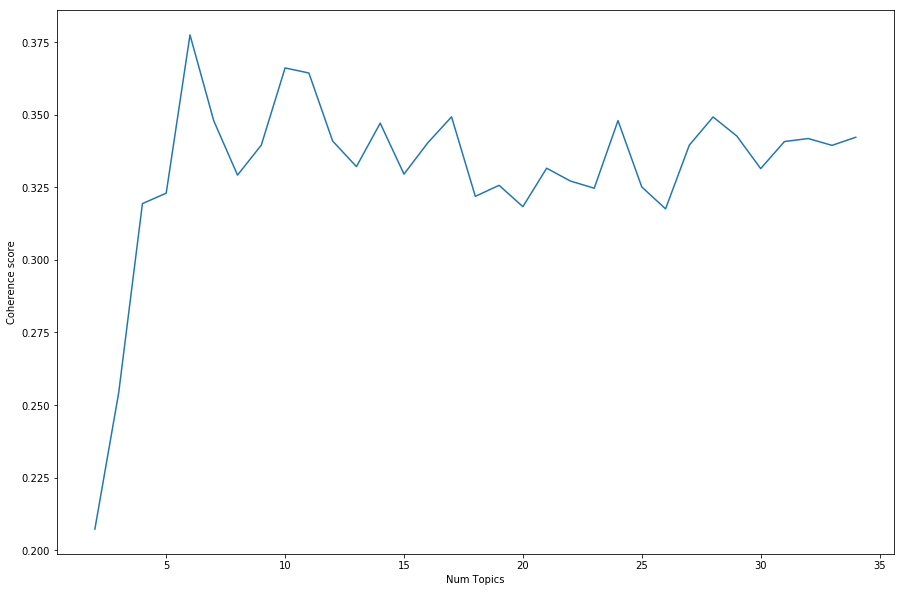

In [47]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.207273
Num Topics = 3  has Coherence Value of 0.25413
Num Topics = 4  has Coherence Value of 0.319381
Num Topics = 5  has Coherence Value of 0.32296
Num Topics = 6  has Coherence Value of 0.377471
Num Topics = 7  has Coherence Value of 0.347892
Num Topics = 8  has Coherence Value of 0.329183
Num Topics = 9  has Coherence Value of 0.339533
Num Topics = 10  has Coherence Value of 0.366098
Num Topics = 11  has Coherence Value of 0.364352
Num Topics = 12  has Coherence Value of 0.340918
Num Topics = 13  has Coherence Value of 0.332118
Num Topics = 14  has Coherence Value of 0.347078
Num Topics = 15  has Coherence Value of 0.329526
Num Topics = 16  has Coherence Value of 0.340304
Num Topics = 17  has Coherence Value of 0.349247
Num Topics = 18  has Coherence Value of 0.321872
Num Topics = 19  has Coherence Value of 0.32567
Num Topics = 20  has Coherence Value of 0.318318
Num Topics = 21  has Coherence Value of 0.331558
Num Topics = 22  has Coherence 

In [49]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 8
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -9.17411212814751
Coherence Score:  0.31182376680729157


/anaconda3/envs/py3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [51]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['вронский', 'анна', 'еи', 'время', 'нея', 'приезжать', 'день', 'сделать', 'оставаться', 'поехать']
Topic 1: ['который', 'знать', 'делать', 'иметь', 'думать', 'чувство', 'новый', 'давать', 'казаться', 'должный']
Topic 2: ['свой', 'который', 'жизнь', 'чувствовать', 'муж', 'весь', 'мысль', 'положение', 'жить', 'своеи']
Topic 3: ['рука', 'лицо', 'глаз', 'смотреть', 'голова', 'взгляд', 'выражение', 'пред', 'глядеть', 'останавливаться']
Topic 4: ['выходить', 'входить', 'александровна', 'дарья', 'пойти', 'стоять', 'садиться', 'вставать', 'дом', 'дверь']
Topic 5: ['алексей', 'александрович', 'дело', 'жена', 'свой', 'ехать', 'место', 'минута', 'очевидно', 'принимать']
Topic 6: ['левин', 'сказать', 'очень', 'степан', 'аркадьич', 'отвечать', 'улыбаться', 'брат', 'сергей', 'разговор']
Topic 7: ['сказать', 'говорить', 'кити', 'спрашивать', 'слово', 'долли', 'княгиня', 'голос', 'начинать', 'слушать']
Topic 8: ['мочь', 'знать', 'видеть', 'понимать', 'человек', 'любить', 'женщина', 'мать', '

In [52]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [53]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

Dominant_Topic  \
0   0.0              
1   1.0              
2   2.0              
3   3.0              
4   4.0              
5   5.0              
6   6.0              
7   7.0              
8   8.0              
9   9.0              
10  10.0             
11  11.0             
12  12.0             
13  13.0             
14  14.0             
15  15.0             
16  16.0             
17  17.0             

                                                                                Topic_Keywords  \
0   степан, аркадьич, сказать, облонский, очень, знать, давать, улыбаться, место, дело           
1   мужик, левин, дорога, старик, земля, хозяиства, хозяиство, рабочий, свой, год                
2   нога, лошадь, который, кучер, самый, место, вагон, ласка, весловския, болото                 
3   доктор, рука, чувствовать, чувство, смерть, голова, становиться, свой, умирать, бог          
4   анна, еи, сказать, нея, муж, мочь, видеть, сын, который, положение                           
5   долли, ребенок, александровна, дарья, анна, сказать, еи, очень, детея, видеть                
6   мочь, знать, думать, свой, любить, говорить, чувствовать, хотеть, жизнь, который             
7   вронский, который, свой, знать, человек, яшвин, женщина, улыбаться, понимать, молодой        
8   пойти, свой, идти, весь, движение, шаг, время, белый, становиться, останавливаться           
9   сказать, говорить, разговор, очень, стол, обращаться, спрашивать, улыбкои, очевидно, жена    
10  кити, княгиня, князь, варенька, сказать, еи, говорить, мать, нея, который                    
11  дело, свой, который, отношение, время, иметь, нужно, деньги, новый, занимать                 
12  который, мысль, жизнь, знать, самый, человек, вопрос, своеи, новый, видеть                   
13  алексей, александрович, жена, графиня, сережа, который, лидия, ивановна, свой, мочь          
14  сергей, иванович, сказать, говорить, дело, видеть, народ, свияжския, человек, разговор       
15  сказать, говорить, лицо, рука, глаз, понимать, хотеть, голос, глядеть, слово                 
16  левин, брат, который, константин, знать, николай, становиться, деревня, агафья, михаиловна   
17  день, приезжать, который, очень, человек, веселый, самый, поехать, время, дом                

    Num_Documents  Percent_Documents  
0   3132.0         0.1549             
1   1934.0         0.0956             
2   1755.0         0.0868             
3   1976.0         0.0977             
4   2081.0         0.1029             
5   1881.0         0.0930             
6   1981.0         0.0980             
7   2014.0         0.0996             
8   1866.0         0.0923             
9   1604.0         0.0793             
10 NaN            NaN                 
11 NaN            NaN                 
12 NaN            NaN                 
13 NaN            NaN                 
14 NaN            NaN                 
15 NaN            NaN                 
16 NaN            NaN                 
17 NaN            NaN

## Use stemming instead of lemmatization

In [55]:
from nltk.stem.snowball import SnowballStemmer

In [56]:
stemmer = SnowballStemmer("russian")

In [57]:
def stemming(texts):
    text_out = []
    for doc in texts:
        text = " ".join(doc)
        tokens = stemmer.stem(text)
        tokens = [token for token in tokens if token not in russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]
        text_out.append(tokens)
    return text_out

In [95]:
def stemming(texts):
    text_out = []
    for doc in texts:
        text = [stemmer.stem(word) for word in doc]
        tokens = [word for word in text if word not in russian_stopwords\
                  and word != " " \
                  and word.strip() not in punctuation]
        text_out.append(tokens)
    return text_out

In [98]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#Create lemmatizer and stopwords list
russian_stopwords = stopwords.words("russian")

# Do stemming
data_stemmed = stemming(data_words_bigrams)

print(data_stemmed[:1])

[['счастлив', 'сем', 'похож', 'друг_друг', 'кажд', 'несчастлив', 'сем', 'несчастлив', 'сво']]


In [99]:
# Create Dictionary
id2word = corpora.Dictionary(data_stemmed)

# Create Corpus
texts = data_stemmed

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1)]]


In [100]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('друг_друг', 1),
  ('кажд', 1),
  ('несчастлив', 2),
  ('похож', 1),
  ('сво', 1),
  ('сем', 2),
  ('счастлив', 1)]]

In [101]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [102]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_stemmed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -10.366378606621854
Coherence Score:  0.43049726127829213


In [103]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/envs/py3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [104]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [105]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_stemmed,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


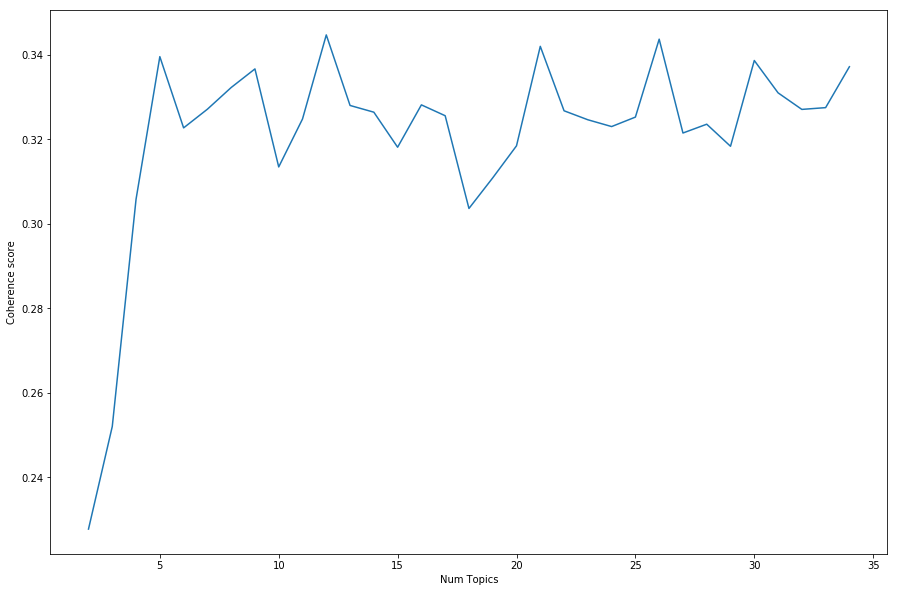

In [106]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [107]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.227771
Num Topics = 3  has Coherence Value of 0.252058
Num Topics = 4  has Coherence Value of 0.305844
Num Topics = 5  has Coherence Value of 0.339596
Num Topics = 6  has Coherence Value of 0.322737
Num Topics = 7  has Coherence Value of 0.327155
Num Topics = 8  has Coherence Value of 0.332288
Num Topics = 9  has Coherence Value of 0.336694
Num Topics = 10  has Coherence Value of 0.313492
Num Topics = 11  has Coherence Value of 0.324836
Num Topics = 12  has Coherence Value of 0.344742
Num Topics = 13  has Coherence Value of 0.328042
Num Topics = 14  has Coherence Value of 0.32645
Num Topics = 15  has Coherence Value of 0.318158
Num Topics = 16  has Coherence Value of 0.328182
Num Topics = 17  has Coherence Value of 0.325612
Num Topics = 18  has Coherence Value of 0.303663
Num Topics = 19  has Coherence Value of 0.310909
Num Topics = 20  has Coherence Value of 0.318491
Num Topics = 21  has Coherence Value of 0.342038
Num Topics = 22  has Coherenc

In [108]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 16
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"врем" + 0.036*"сво" + 0.030*"прост" + 0.023*"подума" + 0.022*"минут" '
  '+ 0.021*"должн" + 0.020*"еха" + 0.020*"реш" + 0.019*"час" + 0.018*"каза"'),
 (1,
  '0.056*"дума" + 0.042*"люб" + 0.036*"нужн" + 0.035*"человек" + '
  '0.028*"алексеи_александрович" + 0.024*"говор" + 0.024*"мест" + '
  '0.023*"хорош" + 0.017*"долг" + 0.016*"правд"'),
 (2,
  '0.062*"лиц" + 0.054*"глаз" + 0.051*"вронск" + 0.029*"взгляд" + '
  '0.025*"останов" + 0.025*"лошад" + 0.024*"гляд" + 0.020*"смотрел" + '
  '0.013*"улыбк" + 0.013*"слез"'),
 (3,
  '0.080*"одн" + 0.059*"друг" + 0.046*"котор" + 0.038*"мысл" + 0.029*"вопрос" '
  '+ 0.027*"люд" + 0.019*"отношен" + 0.016*"сторон" + 0.014*"главн" + '
  '0.013*"общ"'),
 (4,
  '0.085*"сво" + 0.051*"дела" + 0.048*"знал" + 0.038*"видел" + 0.037*"могл" + '
  '0.032*"поня" + 0.032*"муж" + 0.030*"хот" + 0.022*"всем" + 0.021*"дума"'),
 (5,
  '0.095*"е" + 0.050*"кит" + 0.045*"хотел" + 0.045*"стал" + 0.020*"свет" + '
  '0.018*"стар" + 0.017*"вареньк" + 0.016*"бо

In [109]:
optimal_model.show_topic(0,10)

[('врем', 0.03786553361659585),
 ('сво', 0.03586603349162709),
 ('прост', 0.02999250187453137),
 ('подума', 0.023369157710572356),
 ('минут', 0.02186953261684579),
 ('должн', 0.021119720069982504),
 ('еха', 0.019995001249687578),
 ('реш', 0.019745063734066485),
 ('час', 0.019245188702824295),
 ('каза', 0.01812046988252937)]

In [110]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['врем', 'сво', 'прост', 'подума', 'минут', 'должн', 'еха', 'реш', 'час', 'каза']
Topic 1: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович', 'говор', 'мест', 'хорош', 'долг', 'правд']
Topic 2: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов', 'лошад', 'гляд', 'смотрел', 'улыбк', 'слез']
Topic 3: ['одн', 'друг', 'котор', 'мысл', 'вопрос', 'люд', 'отношен', 'сторон', 'главн', 'общ']
Topic 4: ['сво', 'дела', 'знал', 'видел', 'могл', 'поня', 'муж', 'хот', 'всем', 'дума']
Topic 5: ['е', 'кит', 'хотел', 'стал', 'свет', 'стар', 'вареньк', 'больн', 'показа', 'стран']
Topic 6: ['двер', 'комнат', 'больш', 'слыша', 'сел', 'знаком', 'стоя', 'выход', 'увида', 'степан_аркадьич']
Topic 7: ['левин', 'дет', 'мужик', 'сто', 'труд', 'пошел', 'ве', 'дорог', 'ден', 'деревн']
Topic 8: ['говор', 'ан', 'вронск', 'женщин', 'зна', 'голос', 'знает', 'давн', 'мат', 'прибав']
Topic 9: ['жизн', 'чувств', 'чувствова', 'нем', 'душ', 'счаст', 'ужасн', 'сердц', 'это', 'почувствова']
Topic 10: ['сво', 'с

In [111]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0      0            4.0             0.1149               
1      1            11.0            0.0901               
2      2            12.0            0.0935               
3      3            11.0            0.0944               
4      4            11.0            0.1307               
5      5            4.0             0.0858               
6      6            7.0             0.1155               
7      7            14.0            0.1716               
8      8            0.0             0.0556               
9      9            1.0             0.0860               
10     10           0.0             0.0556               
11     11           0.0             0.0556               
12     12           9.0             0.0853               
13     13           13.0            0.0726               
14     14           10.0            0.1012               
15     15           2.0             0.0952               
16     16           13.0            0.0741               
17     17           3.0             0.0873               
18     18           14.0            0.1495               
19     19           2.0             0.0783               
20     20           16.0            0.1090               
21     21           3.0             0.0741               
22     22           1.0             0.0726               
23     23           4.0             0.0801               
24     24           0.0             0.0556               
25     25           0.0             0.0919               
26     26           1.0             0.0788               
27     27           17.0            0.0692               
28     28           16.0            0.1090               
29     29           9.0             0.1014               
30     30           6.0             0.1261               
31     31           9.0             0.0909               
32     32           0.0             0.0556               
33     33           0.0             0.0556               
34     34           2.0             0.0713               
35     35           10.0            0.0926               
36     36           9.0             0.0824               
37     37           11.0            0.0778               
38     38           11.0            0.0810               
39     39           1.0             0.0964               
40     40           0.0             0.0700               
41     41           6.0             0.0838               
42     42           5.0             0.0823               
43     43           1.0             0.0994               
44     44           4.0             0.0741               
45     45           4.0             0.0741               
46     46           4.0             0.0782               
47     47           16.0            0.0700               
48     48           9.0             0.0952               
49     49           7.0             0.0960               
50     50           10.0            0.0885               
51     51           5.0             0.0675               
52     52           12.0            0.1034               
53     53           5.0             0.0758               
54     54           0.0             0.0923               
55     55           1.0             0.0726               
56     56           9.0             0.0726               
57     57           16.0            0.0719               
58     58           9.0             0.0741               
59     59           4.0             0.0947               
60     60           3.0             0.0741               
61     61           5.0             0.1184               
62     62           1.0             0.0700               
63     63           17.0            0.0741               
64     64           10.0            0.0747               
65     65           11.0            0.0741               
66     66           2.0             0.0824               
67     67           5.0             0.0929               
68   

In [112]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
8      8            0.0             0.0556               
9      9            1.0             0.0860               
10     10           0.0             0.0556               
11     11           0.0             0.0556               
22     22           1.0             0.0726               
24     24           0.0             0.0556               
25     25           0.0             0.0919               
26     26           1.0             0.0788               
32     32           0.0             0.0556               
33     33           0.0             0.0556               
39     39           1.0             0.0964               
40     40           0.0             0.0700               
43     43           1.0             0.0994               
54     54           0.0             0.0923               
55     55           1.0             0.0726               
62     62           1.0             0.0700               
106    106          0.0             0.0556               
111    111          0.0             0.0719               
112    112          1.0             0.0675               
113    113          0.0             0.0556               
119    119          0.0             0.0556               
130    130          1.0             0.0663               
133    133          0.0             0.0726               
136    136          0.0             0.0810               
156    156          0.0             0.0838               
167    167          0.0             0.0720               
180    180          0.0             0.0556               
200    200          0.0             0.0877               
204    204          0.0             0.0869               
205    205          0.0             0.1406               
208    208          0.0             0.1130               
215    215          0.0             0.0713               
216    216          1.0             0.1036               
218    218          1.0             0.0741               
223    223          0.0             0.0556               
235    235          0.0             0.1389               
243    243          0.0             0.0700               
263    263          1.0             0.0713               
264    264          0.0             0.0844               
270    270          0.0             0.0919               
289    289          0.0             0.0754               
291    291          1.0             0.0885               
293    293          0.0             0.0713               
300    300          0.0             0.0741               
308    308          1.0             0.0726               
309    309          0.0             0.0713               
312    312          0.0             0.0741               
314    314          1.0             0.0675               
321    321          1.0             0.0901               
322    322          1.0             0.0741               
329    329          0.0             0.0900               
331    331          1.0             0.1147               
332    332          1.0             0.0687               
333    333          0.0             0.0853               
341    341          0.0             0.0556               
356    356          0.0             0.1058               
369    369          1.0             0.0755               
375    375          0.0             0.0556               
387    387          0.0             0.0700               
388    388          1.0             0.1020               
394    394          1.0             0.0761               
399    399          0.0             0.0556               
400    400          0.0             0.0556               
414    414          0.0             0.0556               
421    421          0.0             0.0556               
422    422          0.0             0.0556               
427    427          0.0             0.0556               
435    435          0.0             0.0700               
436  

In [113]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['сво,',
  'дела,',
  'знал,',
  'видел,',
  'могл,',
  'поня,',
  'муж,',
  'хот,',
  'всем,',
  'дума'],
 ['особен,',
  'дом,',
  'которы,',
  'весел,',
  'вид,',
  'сын,',
  'вмест,',
  'доктор,',
  'нынч,',
  'облонск'],
 ['левин,',
  'жен,',
  'брат,',
  'разговор,',
  'княгин,',
  'приеха,',
  'тотчас,',
  'сергеи_иванович,',
  'очевидн,',
  'обрат'],
 ['особен,',
  'дом,',
  'которы,',
  'весел,',
  'вид,',
  'сын,',
  'вмест,',
  'доктор,',
  'нынч,',
  'облонск'],
 ['особен,',
  'дом,',
  'которы,',
  'весел,',
  'вид,',
  'сын,',
  'вмест,',
  'доктор,',
  'нынч,',
  'облонск'],
 ['сво,',
  'дела,',
  'знал,',
  'видел,',
  'могл,',
  'поня,',
  'муж,',
  'хот,',
  'всем,',
  'дума'],
 ['левин,',
  'дет,',
  'мужик,',
  'сто,',
  'труд,',
  'пошел,',
  'ве,',
  'дорог,',
  'ден,',
  'деревн'],
 ['рук,',
  'голов,',
  'быстр,',
  'ног,',
  'подня,',
  'движен,',
  'плат,',
  'маленьк,',
  'взял,',
  'сидел'],
 ['врем,',
  'сво,',
  'прост,',
  'подума,',
  'минут,',
  'должн,

In [114]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
1. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
2. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
3. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
4. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
5. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
6. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
7. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
8. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
9. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
10. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
11. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
12. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
13. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
14. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']


909. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
910. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
911. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
912. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
913. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
914. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
915. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
916. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
917. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
918. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
919. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
920. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
921. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
922. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
923. Dominant keywords: ['врем', 'сво', 'прост', 'подум

1823. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
1824. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
1825. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
1826. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
1827. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
1828. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
1829. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
1830. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
1831. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
1832. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
1833. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
1834. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
1835. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
1836. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
1

2628. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
2629. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
2630. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
2631. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
2632. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
2633. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
2634. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
2635. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
2636. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
2637. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
2638. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
2639. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
2640. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
2641. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
2642. Dominant keywords: ['дума', 'люб',

3495. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
3496. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
3497. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
3498. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
3499. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
3500. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
3501. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
3502. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
3503. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
3504. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
3505. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
3506. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
3507. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
3508. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
3509. Dominant keywords: ['сказа', 'степан_а

4352. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
4353. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
4354. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
4355. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
4356. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
4357. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
4358. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
4359. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
4360. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
4361. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
4362. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
4363. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
4364. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
4365. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']

5233. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
5234. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
5235. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
5236. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
5237. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
5238. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
5239. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
5240. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
5241. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
5242. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
5243. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
5244. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
5245. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
5246. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
5247. Dominant keywords: ['лиц', 'глаз', 

6123. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
6124. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
6125. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
6126. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
6127. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
6128. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
6129. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
6130. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
6131. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
6132. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
6133. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
6134. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
6135. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
6136. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
6137. Dominant keywords: ['говор', 'ан'

7005. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
7006. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
7007. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
7008. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
7009. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
7010. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
7011. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
7012. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
7013. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
7014. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
7015. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
7016. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
7017. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
7018. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
7019. Domina

7900. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
7901. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
7902. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
7903. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
7904. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
7905. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
7906. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
7907. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
7908. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
7909. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
7910. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
7911. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
7912. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
7913. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
7914. Dom

8820. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
8821. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
8822. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
8823. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
8824. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
8825. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
8826. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
8827. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
8828. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
8829. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
8830. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
8831. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
8832. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
8833. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит

9753. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
9754. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
9755. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
9756. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
9757. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
9758. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
9759. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
9760. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
9761. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
9762. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
9763. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
9764. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
9765. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
9766. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
9767. Dominant keyw

10636. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
10637. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
10638. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
10639. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
10640. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
10641. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
10642. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
10643. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
10644. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
10645. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
10646. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
10647. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
10648. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
10649. Dominant keywords: ['жизн', 'чувств', 'чувс

11565. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
11566. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
11567. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
11568. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
11569. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
11570. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
11571. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
11572. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
11573. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
11574. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
11575. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
11576. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
11577. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
11578. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
11579. Dominant keywords: ['одн', 'друг', 'котор', 'м

12469. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
12470. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
12471. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
12472. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
12473. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
12474. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
12475. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
12476. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
12477. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
12478. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
12479. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
12480. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
12481. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
12482. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
12483. Dominant keywo

13370. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
13371. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
13372. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
13373. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
13374. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
13375. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
13376. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
13377. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
13378. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
13379. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
13380. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
13381. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
13382. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
13383. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
13384. Dominant keywo

14291. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
14292. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
14293. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
14294. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
14295. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
14296. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
14297. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
14298. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
14299. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
14300. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
14301. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
14302. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
14303. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
14304. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
14305. Dominant keywords: ['леви

15177. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
15178. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
15179. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
15180. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
15181. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
15182. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
15183. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
15184. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
15185. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
15186. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
15187. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
15188. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
15189. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
15190. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
1519

16089. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
16090. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
16091. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
16092. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
16093. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
16094. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
16095. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
16096. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
16097. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
16098. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
16099. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
16100. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
16101. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
16102. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
16103. Dominant keywor

16962. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
16963. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
16964. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
16965. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
16966. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
16967. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
16968. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
16969. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
16970. Dominant keywords: ['левин', 'жен', 'брат', 'разговор', 'княгин']
16971. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
16972. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
16973. Dominant keywords: ['сво', 'сдела', 'стол', 'нача', 'спрос']
16974. Dominant keywords: ['сказа', 'степан_аркадьич', 'долл', 'отвеча', 'ан']
16975. Dominant keywords: ['левин', 'дет', 'мужик', 'сто', 'труд']
16976. 

17893. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
17894. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
17895. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
17896. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
17897. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
17898. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
17899. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
17900. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
17901. Dominant keywords: ['сказа', 'очен', 'понима', 'мо', 'кит']
17902. Dominant keywords: ['е', 'кит', 'хотел', 'стал', 'свет']
17903. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
17904. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
17905. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
17906. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
17907. Dominant keywor

18764. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
18765. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
18766. Dominant keywords: ['котор', 'дел', 'положен', 'наш', 'прежд']
18767. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
18768. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
18769. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
18770. Dominant keywords: ['врем', 'сво', 'прост', 'подума', 'минут']
18771. Dominant keywords: ['сво', 'дела', 'знал', 'видел', 'могл']
18772. Dominant keywords: ['особен', 'дом', 'которы', 'весел', 'вид']
18773. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
18774. Dominant keywords: ['мог', 'эт', 'слов', 'нов', 'прав']
18775. Dominant keywords: ['говор', 'ан', 'вронск', 'женщин', 'зна']
18776. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
18777. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
18778. Do

19690. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
19691. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
19692. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
19693. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
19694. Dominant keywords: ['лиц', 'глаз', 'вронск', 'взгляд', 'останов']
19695. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
19696. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
19697. Dominant keywords: ['рук', 'голов', 'быстр', 'ног', 'подня']
19698. Dominant keywords: ['жизн', 'чувств', 'чувствова', 'нем', 'душ']
19699. Dominant keywords: ['дума', 'люб', 'нужн', 'человек', 'алексеи_александрович']
19700. Dominant keywords: ['двер', 'комнат', 'больш', 'слыша', 'сел']
19701. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
19702. Dominant keywords: ['одн', 'друг', 'котор', 'мысл', 'вопрос']
19703. D

In [115]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0   0.0        0.1940               
1   1.0        0.2607               
2   2.0        0.2882               
3   3.0        0.4436               
4   4.0        0.1772               
5   5.0        0.2545               
6   6.0        0.3839               
7   7.0        0.4155               
8   8.0        0.1575               
9   9.0        0.2618               
10  10.0       0.2222               
11  11.0       0.1778               
12  12.0       0.1806               
13  13.0       0.1590               
14  14.0       0.3091               
15  15.0       0.2765               
16  16.0       0.1649               
17  17.0       0.3128               

                                                                               Keywords  \
0   врем, сво, прост, подума, минут, должн, еха, реш, час, каза                           
1   дума, люб, нужн, человек, алексеи_александрович, говор, мест, хорош, долг, правд      
2   лиц, глаз, вронск, взгляд, останов, лошад, гляд, смотрел, улыбк, слез                 
3   одн, друг, котор, мысл, вопрос, люд, отношен, сторон, главн, общ                      
4   сво, дела, знал, видел, могл, поня, муж, хот, всем, дума                              
5   е, кит, хотел, стал, свет, стар, вареньк, больн, показа, стран                        
6   двер, комнат, больш, слыша, сел, знаком, стоя, выход, увида, степан_аркадьич          
7   левин, дет, мужик, сто, труд, пошел, ве, дорог, ден, деревн                           
8   говор, ан, вронск, женщин, зна, голос, знает, давн, мат, прибав                       
9   жизн, чувств, чувствова, нем, душ, счаст, ужасн, сердц, это, почувствова              
10  сво, сдела, стол, нача, спрос, алексеи_александрович, конч, хотел, слуша, скор        
11  особен, дом, которы, весел, вид, сын, вмест, доктор, нынч, облонск                    
12  левин, жен, брат, разговор, княгин, приеха, тотчас, сергеи_иванович, очевидн, обрат   
13  сказа, очен, понима, мо, кит, выражен, ваш, жела, видет, тво                          
14  рук, голов, быстр, ног, подня, движен, плат, маленьк, взял, сидел                     
15  котор, дел, положен, наш, прежд, сил, долж, хозяиств, те, кром                        
16  сказа, степан_аркадьич, долл, отвеча, ан, теб, улыб, улыбко, ах, дарья_александровн   
17  мог, эт, слов, нов, прав, совершен, вер, которо, имел, человек                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Text  
0   Алексей Александрович только успел вернуться к пяти часам, времени своего обеда, и, пообедав с правителем дел, пригласил его с собой вместе ехать на дачу и на скачки.                                                                                                                                                                                                                                                                                                                         

In [116]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: врем, сво, прост, подума, минут, должн, еха, реш, час, каза

Алексей Александрович только успел вернуться к пяти часам, времени своего обеда, и, пообедав с правителем дел, пригласил его с собой вместе ехать на дачу и на скачки.

Topic number 1
Keywords: дума, люб, нужн, человек, алексеи_александрович, говор, мест, хорош, долг, правд

Теперь Алексей Александрович намерен был требовать: во-первых, чтобы составлена была новая комиссия, которой поручено бы было исследовать на месте состояние инородцев; во-вторых, если окажется, что положение инородцев действительно таково, каким оно является из имеющихся в руках комитета официальных данных, то чтобы была назначена еще другая, новая ученая комиссия для исследования причин этого безотрадного положения инородцев с точек зрения: а) политической, б) административной, в) экономической, г)  этнографической, д) материальной и е) религиозной;  в-третьих, чтобы были затребованы от враждебного министерства сведения о тех мера

In [117]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

Dominant_Topic  \
0   0.0              
1   1.0              
2   2.0              
3   3.0              
4   4.0              
5   5.0              
6   6.0              
7   7.0              
8   8.0              
9   9.0              
10  10.0             
11  11.0             
12  12.0             
13  13.0             
14  14.0             
15  15.0             
16  16.0             
17  17.0             

                                                                         Topic_Keywords  \
0   врем, сво, прост, подума, минут, должн, еха, реш, час, каза                           
1   дума, люб, нужн, человек, алексеи_александрович, говор, мест, хорош, долг, правд      
2   лиц, глаз, вронск, взгляд, останов, лошад, гляд, смотрел, улыбк, слез                 
3   одн, друг, котор, мысл, вопрос, люд, отношен, сторон, главн, общ                      
4   сво, дела, знал, видел, могл, поня, муж, хот, всем, дума                              
5   е, кит, хотел, стал, свет, стар, вареньк, больн, показа, стран                        
6   двер, комнат, больш, слыша, сел, знаком, стоя, выход, увида, степан_аркадьич          
7   левин, дет, мужик, сто, труд, пошел, ве, дорог, ден, деревн                           
8   говор, ан, вронск, женщин, зна, голос, знает, давн, мат, прибав                       
9   жизн, чувств, чувствова, нем, душ, счаст, ужасн, сердц, это, почувствова              
10  сво, сдела, стол, нача, спрос, алексеи_александрович, конч, хотел, слуша, скор        
11  особен, дом, которы, весел, вид, сын, вмест, доктор, нынч, облонск                    
12  левин, жен, брат, разговор, княгин, приеха, тотчас, сергеи_иванович, очевидн, обрат   
13  сказа, очен, понима, мо, кит, выражен, ваш, жела, видет, тво                          
14  рук, голов, быстр, ног, подня, движен, плат, маленьк, взял, сидел                     
15  котор, дел, положен, наш, прежд, сил, долж, хозяиств, те, кром                        
16  сказа, степан_аркадьич, долл, отвеча, ан, теб, улыб, улыбко, ах, дарья_александровн   
17  мог, эт, слов, нов, прав, совершен, вер, которо, имел, человек                        

    Num_Documents  Percent_Documents  
0   1931           0.0955             
1   1288           0.0637             
2   1192           0.0589             
3   966            0.0478             
4   1065           0.0527             
5   992            0.0491             
6   1236           0.0611             
7   1100           0.0544             
8   1137           0.0562             
9   1148           0.0568             
10  1016           0.0502             
11  832            0.0411             
12  991            0.0490             
13  1166           0.0577             
14  1117           0.0552             
15  811            0.0401             
16  1356           0.0670             
17  880            0.0435

In [118]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

Dominant_Topic  \
0   0.0              
1   1.0              
2   2.0              
3   3.0              
4   4.0              
5   5.0              
6   6.0              
7   7.0              
8   8.0              
9   9.0              
10  10.0             
11  11.0             
12  12.0             
13  13.0             
14  14.0             
15  15.0             
16  16.0             
17  17.0             

                                                                         Topic_Keywords  \
0   врем, сво, прост, подума, минут, должн, еха, реш, час, каза                           
1   дума, люб, нужн, человек, алексеи_александрович, говор, мест, хорош, долг, правд      
2   лиц, глаз, вронск, взгляд, останов, лошад, гляд, смотрел, улыбк, слез                 
3   одн, друг, котор, мысл, вопрос, люд, отношен, сторон, главн, общ                      
4   сво, дела, знал, видел, могл, поня, муж, хот, всем, дума                              
5   е, кит, хотел, стал, свет, стар, вареньк, больн, показа, стран                        
6   двер, комнат, больш, слыша, сел, знаком, стоя, выход, увида, степан_аркадьич          
7   левин, дет, мужик, сто, труд, пошел, ве, дорог, ден, деревн                           
8   говор, ан, вронск, женщин, зна, голос, знает, давн, мат, прибав                       
9   жизн, чувств, чувствова, нем, душ, счаст, ужасн, сердц, это, почувствова              
10  сво, сдела, стол, нача, спрос, алексеи_александрович, конч, хотел, слуша, скор        
11  особен, дом, которы, весел, вид, сын, вмест, доктор, нынч, облонск                    
12  левин, жен, брат, разговор, княгин, приеха, тотчас, сергеи_иванович, очевидн, обрат   
13  сказа, очен, понима, мо, кит, выражен, ваш, жела, видет, тво                          
14  рук, голов, быстр, ног, подня, движен, плат, маленьк, взял, сидел                     
15  котор, дел, положен, наш, прежд, сил, долж, хозяиств, те, кром                        
16  сказа, степан_аркадьич, долл, отвеча, ан, теб, улыб, улыбко, ах, дарья_александровн   
17  мог, эт, слов, нов, прав, совершен, вер, которо, имел, человек                        

    Num_Documents  Percent_Documents  
0   1931           0.0955             
1   1288           0.0637             
2   1192           0.0589             
3   966            0.0478             
4   1065           0.0527             
5   992            0.0491             
6   1236           0.0611             
7   1100           0.0544             
8   1137           0.0562             
9   1148           0.0568             
10  1016           0.0502             
11  832            0.0411             
12  991            0.0490             
13  1166           0.0577             
14  1117           0.0552             
15  811            0.0401             
16  1356           0.0670             
17  880            0.0435